In [1]:
# imports
import os
import pathlib
import csv
import pickle
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip3 install opencv-python # uncomment if cv2 isnt available
import cv2
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.metrics import classification_report
import seaborn as sns
import tqdm

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
!pip3 install xgboost # uncomment if xgboost isnt available
from xgboost import XGBClassifier

# Read and analyse the data

In [2]:
def read_data(root_path):
    features = []
    labels = []
    path = pathlib.Path(root_path)
    for f_name in path.glob('*/*.csv'):
        current_dir = pathlib.Path(f_name).parent
        with open(f_name) as f:
            csv_reader = csv.reader(f, delimiter=';')
            next(csv_reader) # to avoid the headers
            for row in csv_reader:
                features.append(plt.imread(os.path.join(current_dir, row[0])))
                labels.append(row[7])
    return np.array(features), np.array(labels).astype(np.int8)

In [3]:
%%time

# read the data
train_dir = './data/GTSRB/training/Images/'
test_dir = './data/GTSRB/test/Images/'

train_features, train_labels = read_data(train_dir)
test_features, test_labels = read_data(test_dir)

# shuffle the data
train_features, train_labels = shuffle(train_features, train_labels, random_state=0)
test_features, test_labels = shuffle(test_features, test_labels, random_state=0)

CPU times: user 4.95 s, sys: 827 ms, total: 5.78 s
Wall time: 6.74 s


In [4]:
print(f'Number of training examples = {train_features.shape[0]}')
print(f'Number of testing examples = {test_features.shape[0]}')
print(f'Number of different shapes = {len(set([img.shape for img in train_features]))}')
print(f'Pixel range = [{np.min(train_features[0])}, {np.max(train_features[0])}]')
print(f'Number of classes = {len(set(train_labels))}')

Number of training examples = 39209
Number of testing examples = 12569
Number of different shapes = 2924
Pixel range = [19, 255]
Number of classes = 43


<BarContainer object of 43 artists>

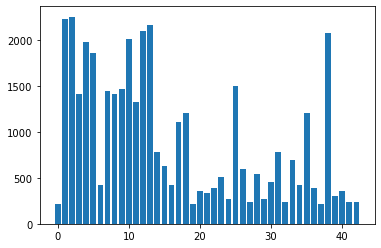

In [5]:
class_distribution = []
for c in set(train_labels):
    class_distribution.append([c, train_labels[train_labels==c].shape[0]])
class_distribution = np.array(class_distribution)
plt.bar(class_distribution[:,0], class_distribution[:,1])

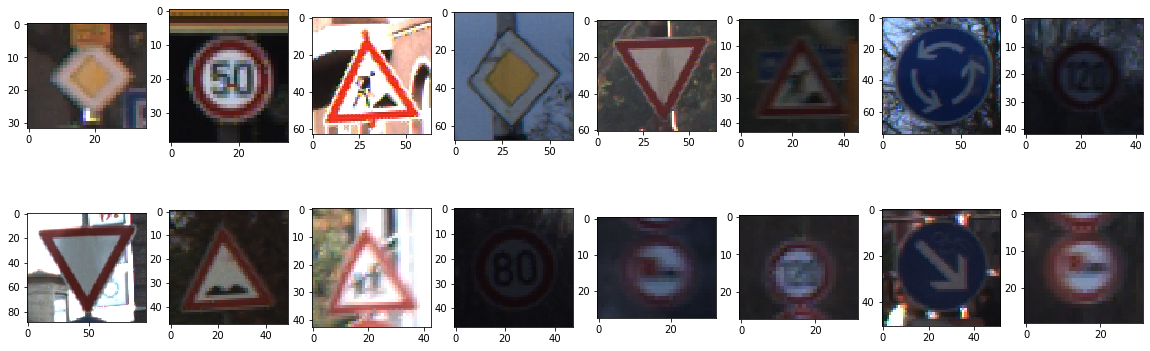

In [6]:
n_images = 16
cols = 8
rows = int(n_images/cols)+1
plt.figure(figsize=(20,10))
for i in range(n_images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(train_features[i])
plt.show()

In [7]:
%%time


def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def preprocess(features, labels):
    # homogenize the size to 32x32, normalize the image and make it flat
    img_size = (32, 32)
    return np.array([normalize(cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)).flatten() for img in features]), labels.flatten()

X_train, y_train = preprocess(train_features, train_labels)
X_test, y_test = preprocess(test_features, test_labels)

CPU times: user 4.23 s, sys: 408 ms, total: 4.64 s
Wall time: 4.65 s


In [8]:
# now they are normalize and with the correct size
print(X_test.shape) # 32x32x3
print(np.mean(X_test[0]))
print(np.std(X_test[0]))

(12569, 3072)
0.0
1.0


# Code for experiments

In [9]:
def experiments(models, X_train, y_train, X_test, y_test, scoring='accuracy'):
    classifi_rep = {}
    cross_val_data = []
    
    for name, model in models.items():
        print(f'########################## {name} ##########################')
        # cross-validation
        cross_val_results = model_selection.cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
        this_df = pd.DataFrame(cross_val_results)
        this_df['model'] = name
        cross_val_data.append(this_df)
        print(name)
        print(this_df)
        # test the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        classifi_rep[name] = classification_report(y_test, y_pred, output_dict=False)
        print(classifi_rep[name])

    return pd.concat(cross_val_data, ignore_index=True), classifi_rep

In [10]:
def report(models, cross_val, exp_name=''):
    # create more data for the statistics
    bootstraps = []
    for model in models.keys():
        model_df = cross_val.loc[cross_val.model == model]
        bootstrap = model_df.sample(n=30, replace=True)
        bootstraps.append(bootstrap)
    # joint everything
    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    
    
    results_long = pd.melt(bootstrap_df, id_vars=['model'], var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time']
    # performance metrics
    results_long_pm = results_long.loc[~results_long['metrics'].isin(time_metrics)]
    #results_long_pm = results_long_pm.sort_values(by='values')
    results_long_ft = results_long.loc[results_long['metrics'].isin(time_metrics)]
    #results_long_ft = results_long_ft.sort_values(by='values')
    
    print('########################## Performance ##########################')
    
    # means and stds for each metric
    metrics = list(set(results_long_pm.metrics.values))
    display(bootstrap_df.groupby(['model'], sort = False)[metrics].agg([np.std, np.mean]))
    
    # First, let’s plot our performance metrics from the 5-fold cross validation.

    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_pm, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of Model by Classification Metric')
    plt.savefig(f'./results/benchmark_models_performance_{exp_name}.png',dpi=300)
    plt.show()
    
    
    print('########################## Time ##########################')
    
    # means and stds for times
    time_metrics = list(set(results_long_ft.metrics.values))
    display(bootstrap_df.groupby(['model'], sort = False)[time_metrics].agg([np.std, np.mean]))
    
    # training and scoring times
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_ft, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of Model by Fit and Score Time')
    plt.savefig(f'./results/benchmark_models_time_{exp_name}.png',dpi=300)
    plt.show()

In [11]:
def analysis(models, exp_name='', force=False):

    # path where to save results
    comparison_path = os.path.join('./results/', exp_name + '.pckl')

    if os.path.exists(comparison_path) and not force:
        # load the results
        with open(comparison_path, 'rb') as f:
            models, cross_val, classifi_rep = pickle.load(f)
    else:
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        cross_val, classifi_rep  = experiments(models, X_train, y_train, X_test, y_test, scoring)

        # save results
        with open(comparison_path, 'wb') as f:
            pickle.dump([models, cross_val, classifi_rep], f)
    
    for name, rep in classifi_rep.items():
        print(f'########################## {name} ##########################')
        print(rep)
        
    report(models, cross_val, exp_name)

# Others

########################## LogReg ##########################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.99      0.99      0.99       450
           4       0.99      1.00      0.99       660
           5       0.99      0.99      0.99       600
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00       480
           8       1.00      1.00      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      1.00      1.00       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       240
          15       1.00      1.00      1.00       210
          16       1

test_accuracy           test_recall_macro            \
                 std      mean               std      mean   
model                                                        
LogReg      0.004358  0.952787          0.004488  0.947823   
RF          0.001763  0.970857          0.001657  0.961802   
KNN         0.003331  0.883899          0.003453  0.878050   
SVM         0.000853  0.959975          0.003013  0.946867   
GNB         0.007391  0.402344          0.008094  0.433188   
XGB         0.001811  0.964808          0.002641  0.950591   

       test_precision_macro           test_f1_macro            
                        std      mean           std      mean  
model                                                          
LogReg             0.004639  0.953958      0.004273  0.950556  
RF                 0.001317  0.980851      0.001075  0.970512  
KNN                0.003624  0.910461      0.003176  0.891686  
SVM                0.001165  0.973607      0.001336  0.958808  
GNB                0.010798  0.478272      0.008577  0.399907  
XGB                0.002422  0.967579      0.002218  0.958423

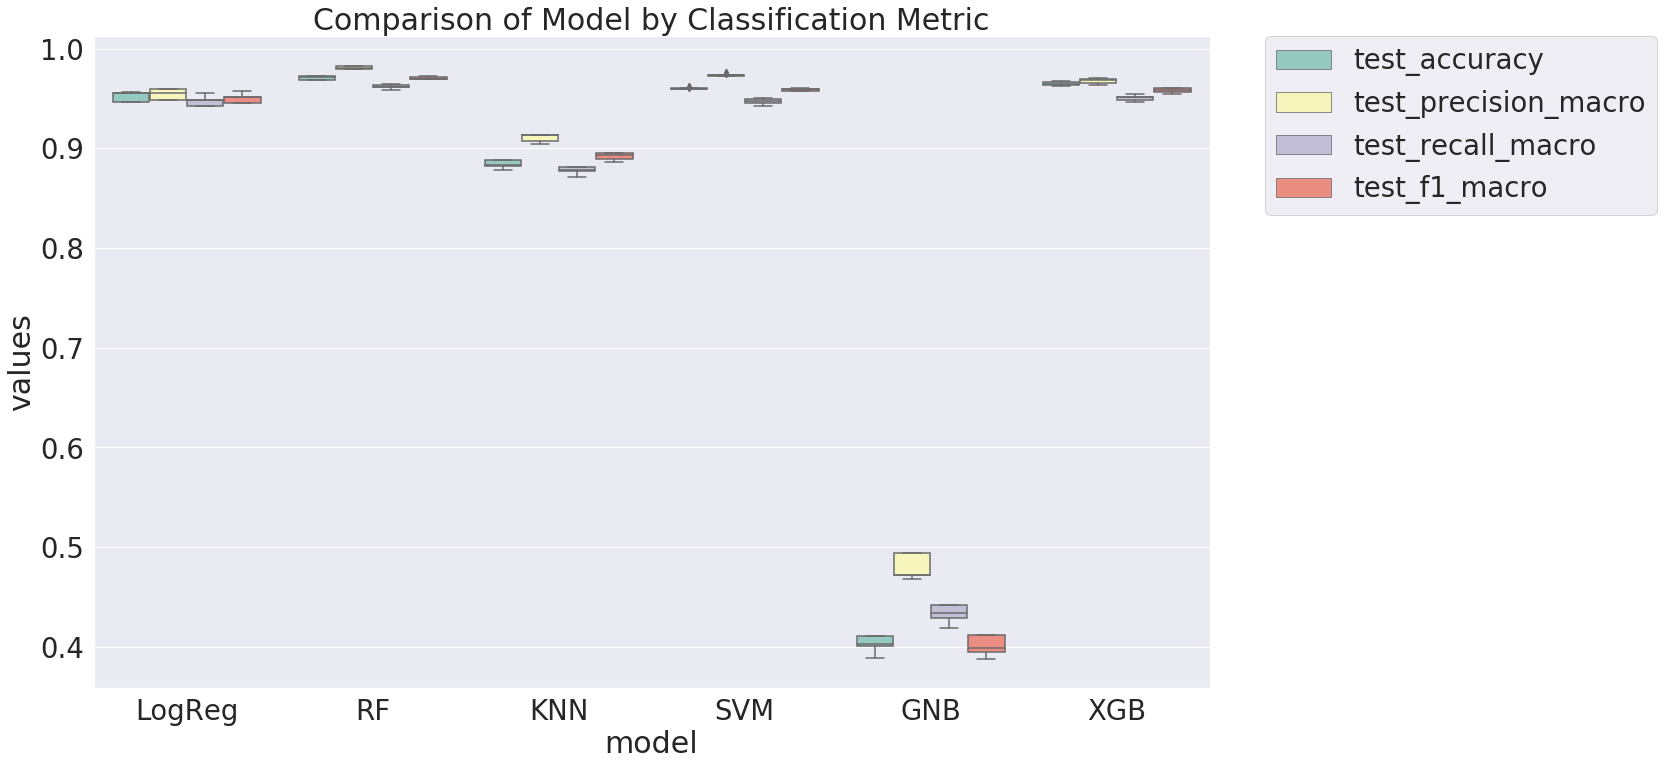

########################## Time ##########################


fit_time              score_time            
             std         mean        std        mean
model                                               
LogReg  1.942729    80.506557   0.010018    0.047112
RF      0.349229    34.127964   0.022175    0.278157
KNN     0.197032    14.072431   1.351655  220.264431
SVM     1.749870  1593.660238   2.485848  511.727219
GNB     0.008540     0.798467   0.007047    3.649391
XGB     1.881422   323.401633   0.009821    0.246736

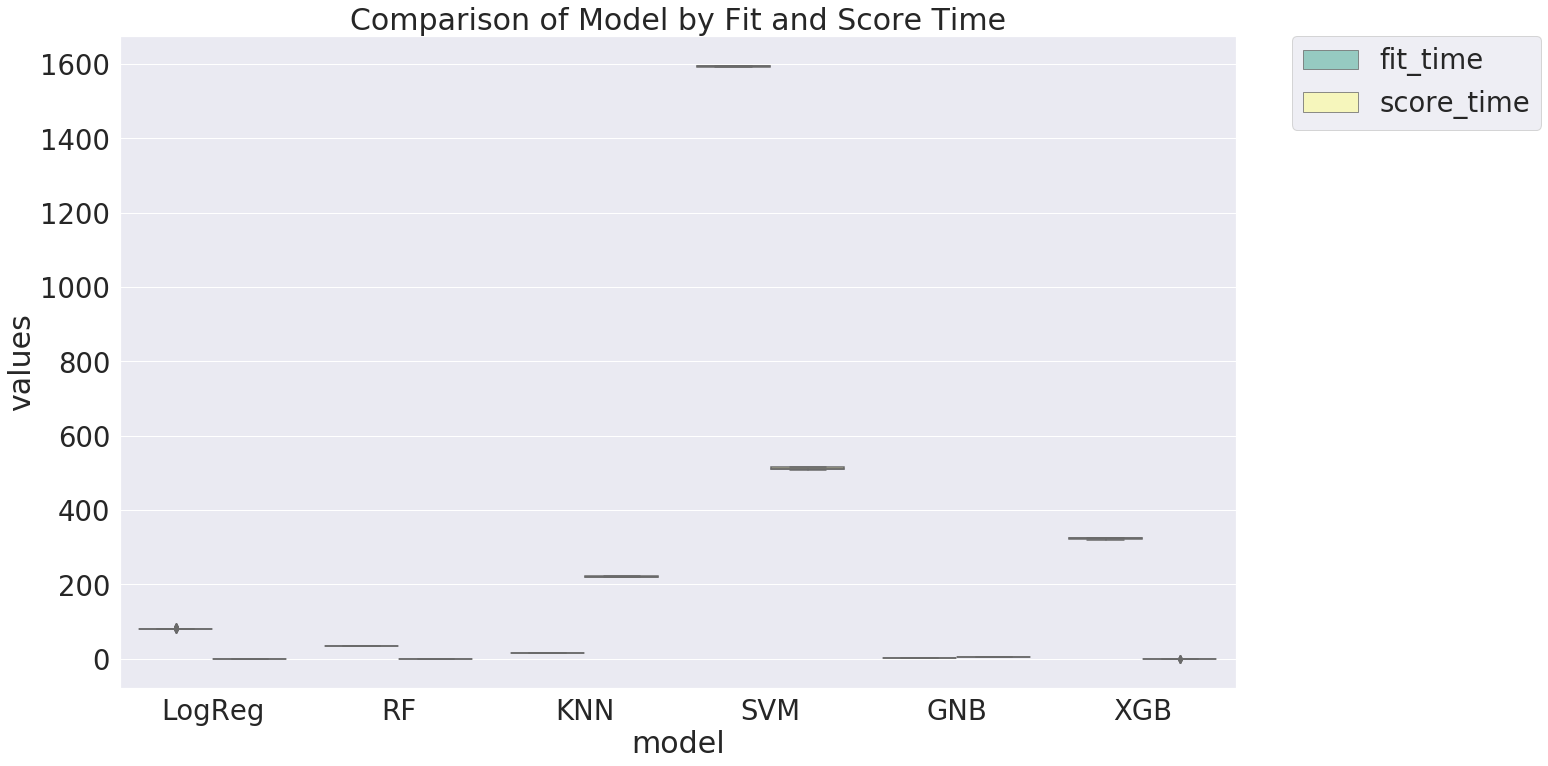

CPU times: user 3.67 s, sys: 1.14 s, total: 4.81 s
Wall time: 4.83 s


In [12]:
%%time

models = {'LogReg': LogisticRegression(n_jobs=12), 
          'RF': RandomForestClassifier(n_jobs=12),
          'KNN': KNeighborsClassifier(n_jobs=12),
          'SVM': SVC(), 
          'GNB': GaussianNB(),
          'XGB': XGBClassifier(objective='multi:softmax', n_jobs=12, tree_method='gpu_hist', gpu_id=0)}
analysis(models, 'others')

# XGBoost

########################## n_estimators_10 ##########################
              precision    recall  f1-score   support

           0       0.82      0.15      0.25        60
           1       0.25      0.92      0.39       720
           2       0.22      0.51      0.30       750
           3       0.14      0.46      0.22       450
           4       0.39      0.27      0.32       660
           5       0.13      0.12      0.12       600
           6       0.84      0.26      0.39       120
           7       0.30      0.12      0.18       480
           8       0.26      0.14      0.18       450
           9       0.71      0.32      0.44       480
          10       0.52      0.19      0.27       660
          11       0.76      0.57      0.65       420
          12       0.85      0.46      0.60       690
          13       0.72      0.66      0.69       720
          14       0.72      0.54      0.62       240
          15       0.82      0.11      0.19       210
          1

test_accuracy           test_recall_macro            \
                           std      mean               std      mean   
model                                                                  
n_estimators_10       0.022882  0.463088          0.020264  0.424431   
n_estimators_50       0.007023  0.570148          0.002652  0.521829   
n_estimators_100      0.012066  0.605049          0.006781  0.551838   

                 test_precision_macro           test_f1_macro            
                                  std      mean           std      mean  
model                                                                    
n_estimators_10              0.018448  0.737068      0.020219  0.493812  
n_estimators_50              0.016163  0.788145      0.005707  0.587657  
n_estimators_100             0.010186  0.801945      0.006174  0.616877

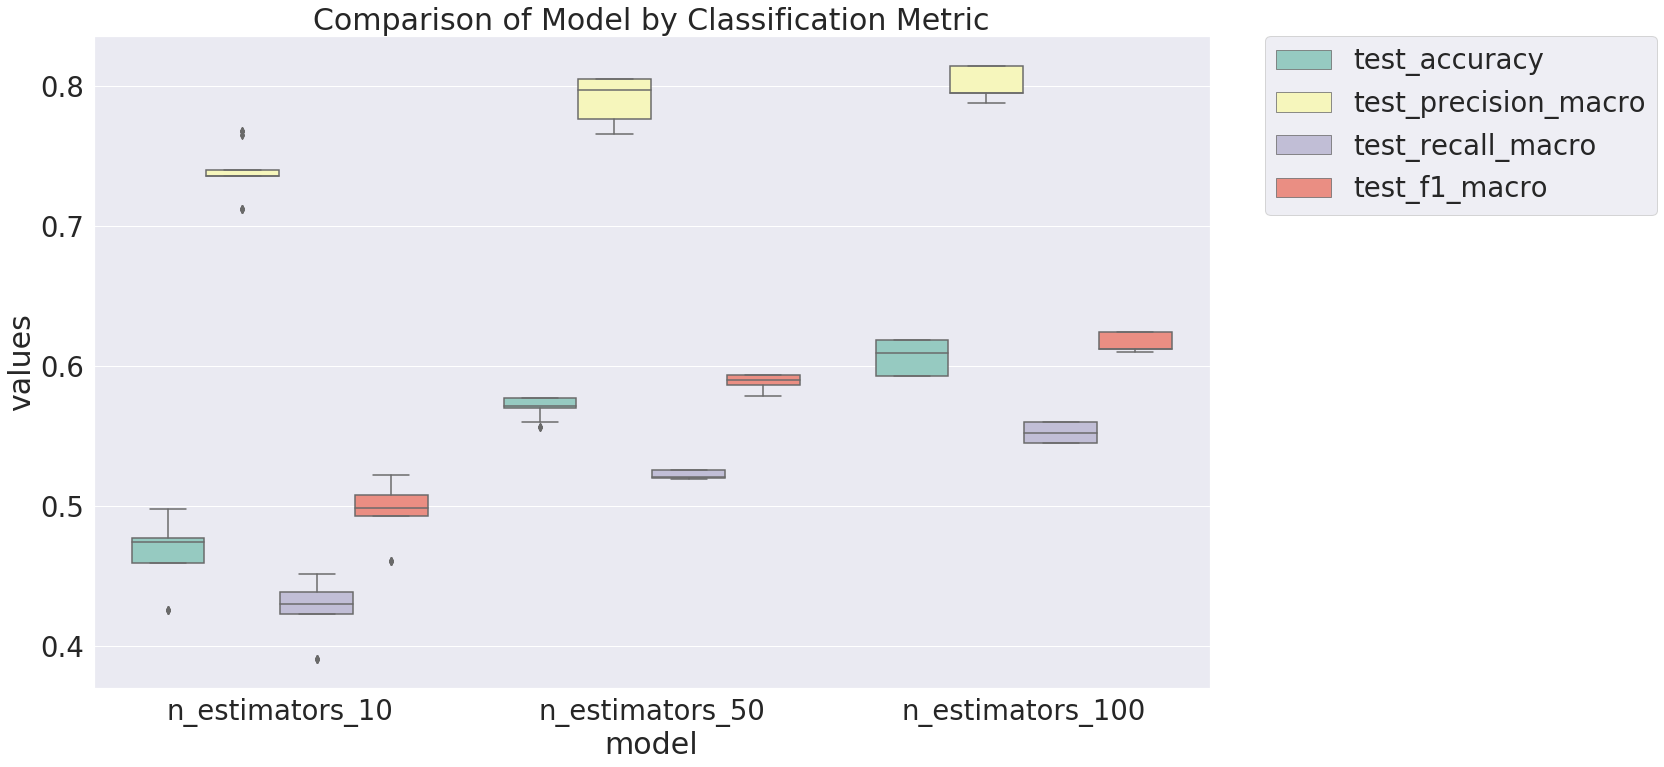

########################## Time ##########################


fit_time             score_time          
                       std        mean        std      mean
model                                                      
n_estimators_10   0.100669   33.669026   0.004772  0.168417
n_estimators_50   0.436807  164.628049   0.003781  0.212510
n_estimators_100  1.086786  329.144820   0.004361  0.269666

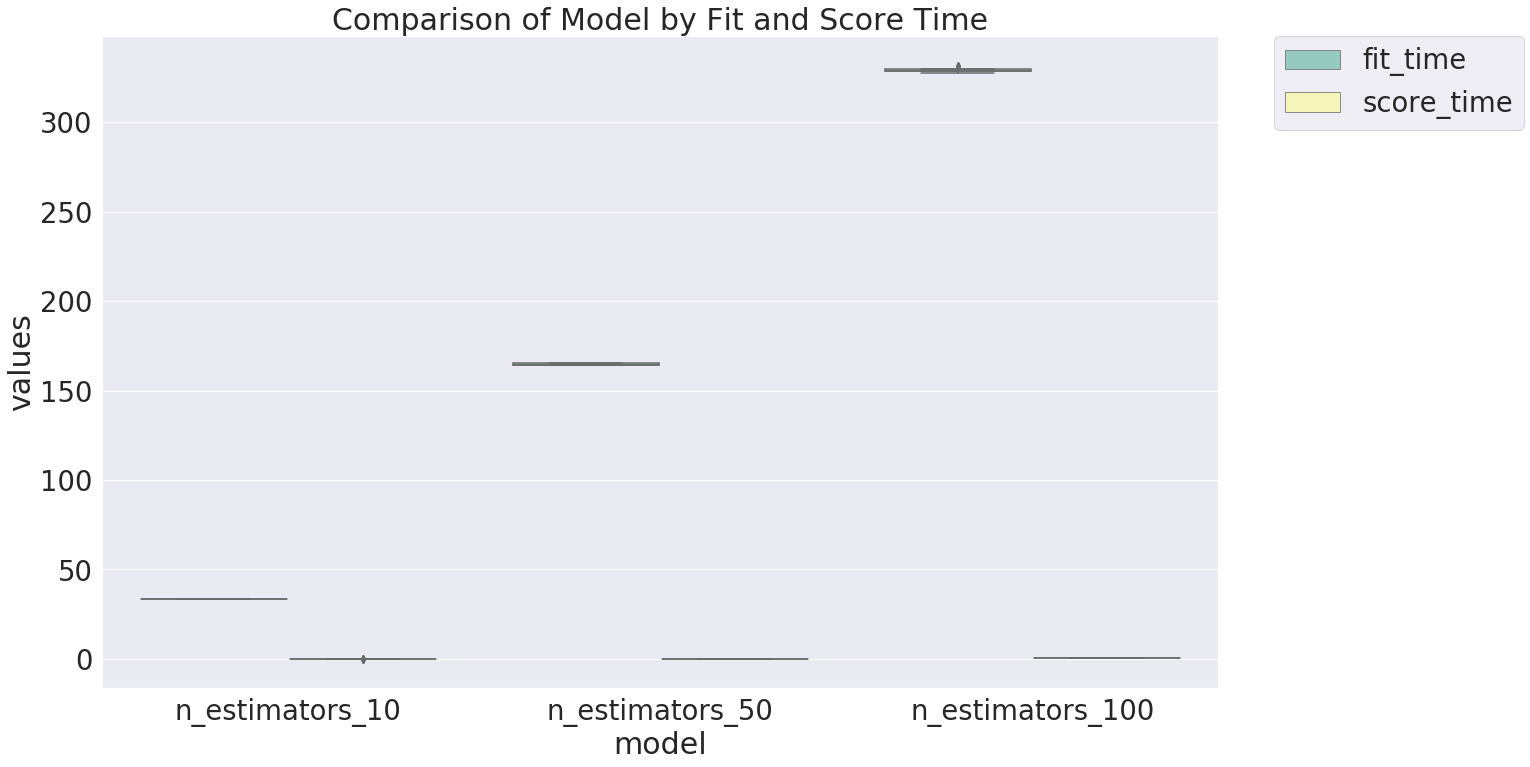

CPU times: user 3.21 s, sys: 9.69 ms, total: 3.22 s
Wall time: 3.22 s


In [13]:
%%time
basic = XGBClassifier(gamma=0.5,
                      learning_rate=0.01, 
                      max_delta_step=0.1, 
                      max_depth=5,
                      min_child_weight=0.2,
                      n_estimators=100,
                      objective='multi:softmax',
                      reg_alpha=0.5,
                      reg_lambda=0.8, 
                      scale_pos_weight=1, 
                      subsample=0.8,
                      n_jobs=12, 
                      gpu_id=0, 
                      tree_method='gpu_hist',
                      validate_parameters=True,
                      verbosity=1)

n_estimators = [10, 50, 100]
models = {}
for n in n_estimators:
    m = copy.deepcopy(basic)
    m.n_estimators = n
    models['n_estimators_' + str(n)] = m

analysis(models, 'xgb_estimators')

########################## learning_rate_0.1 ##########################
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        60
           1       0.60      0.86      0.71       720
           2       0.62      0.79      0.70       750
           3       0.34      0.71      0.46       450
           4       0.61      0.72      0.66       660
           5       0.55      0.50      0.52       600
           6       0.92      0.47      0.62       120
           7       0.80      0.57      0.66       480
           8       0.84      0.58      0.68       450
           9       0.93      0.86      0.89       480
          10       0.91      0.87      0.89       660
          11       0.85      0.87      0.86       420
          12       0.94      0.92      0.93       690
          13       0.87      0.89      0.88       720
          14       0.93      0.82      0.87       240
          15       0.94      0.36      0.52       210
         

test_accuracy           test_recall_macro            \
                              std      mean               std      mean   
model                                                                     
learning_rate_0.1        0.007079  0.705497          0.007211  0.644280   
learning_rate_0.01       0.007651  0.568344          0.002497  0.521417   
learning_rate_0.001      0.005686  0.549785          0.006714  0.504880   

                    test_precision_macro           test_f1_macro            
                                     std      mean           std      mean  
model                                                                       
learning_rate_0.1               0.006164  0.831943      0.007507  0.699100  
learning_rate_0.01              0.015896  0.784522      0.005665  0.586726  
learning_rate_0.001             0.016889  0.777730      0.008960  0.571633

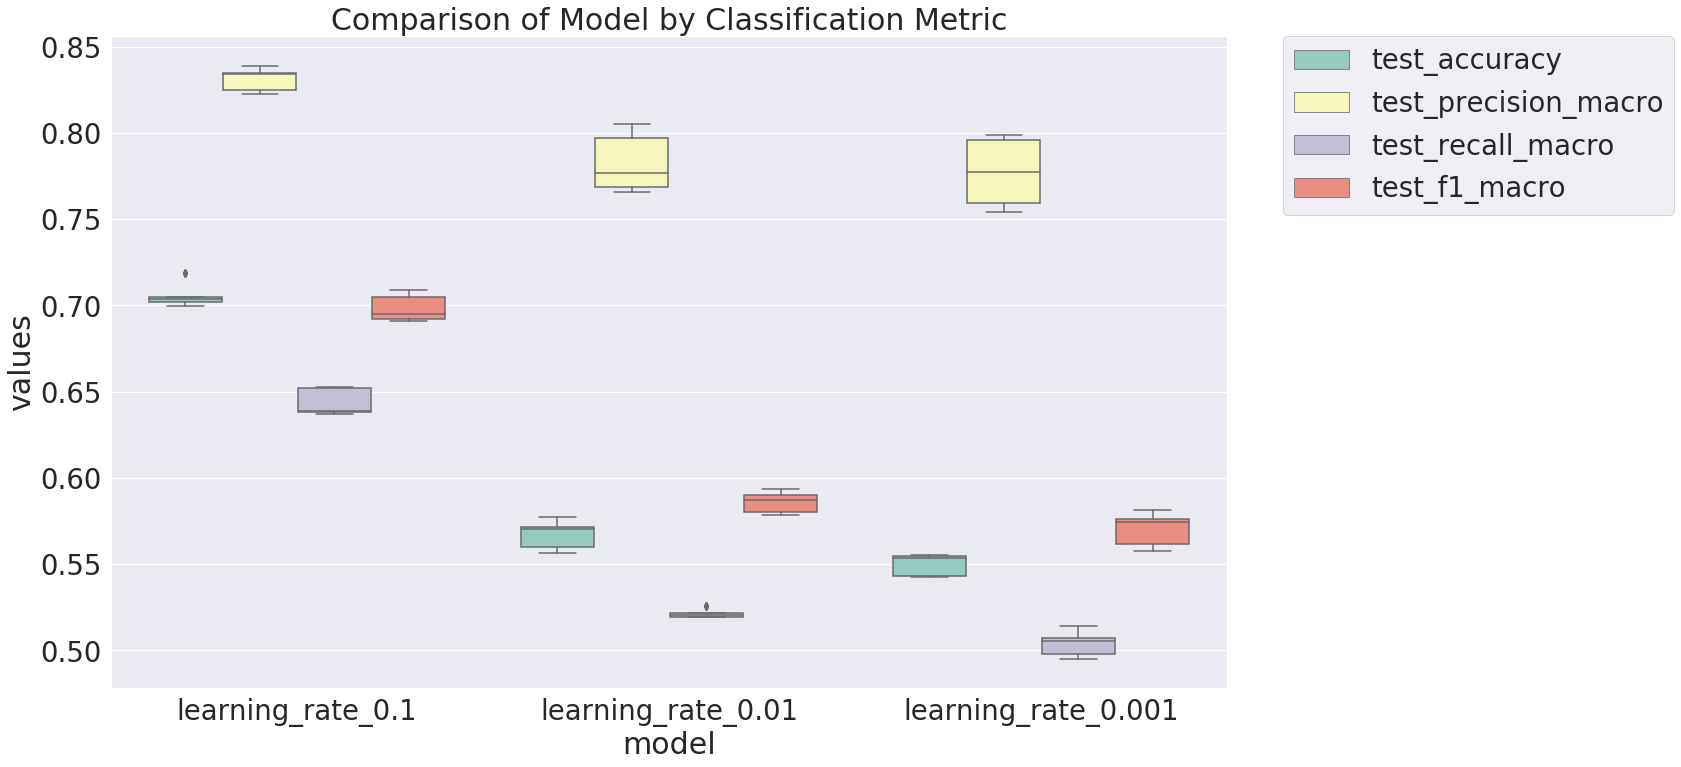

########################## Time ##########################


fit_time             score_time          
                          std        mean        std      mean
model                                                         
learning_rate_0.1    0.391562  166.817429   0.001432  0.213348
learning_rate_0.01   0.381647  164.771225   0.005344  0.217038
learning_rate_0.001  0.345352  164.693274   0.005783  0.215544

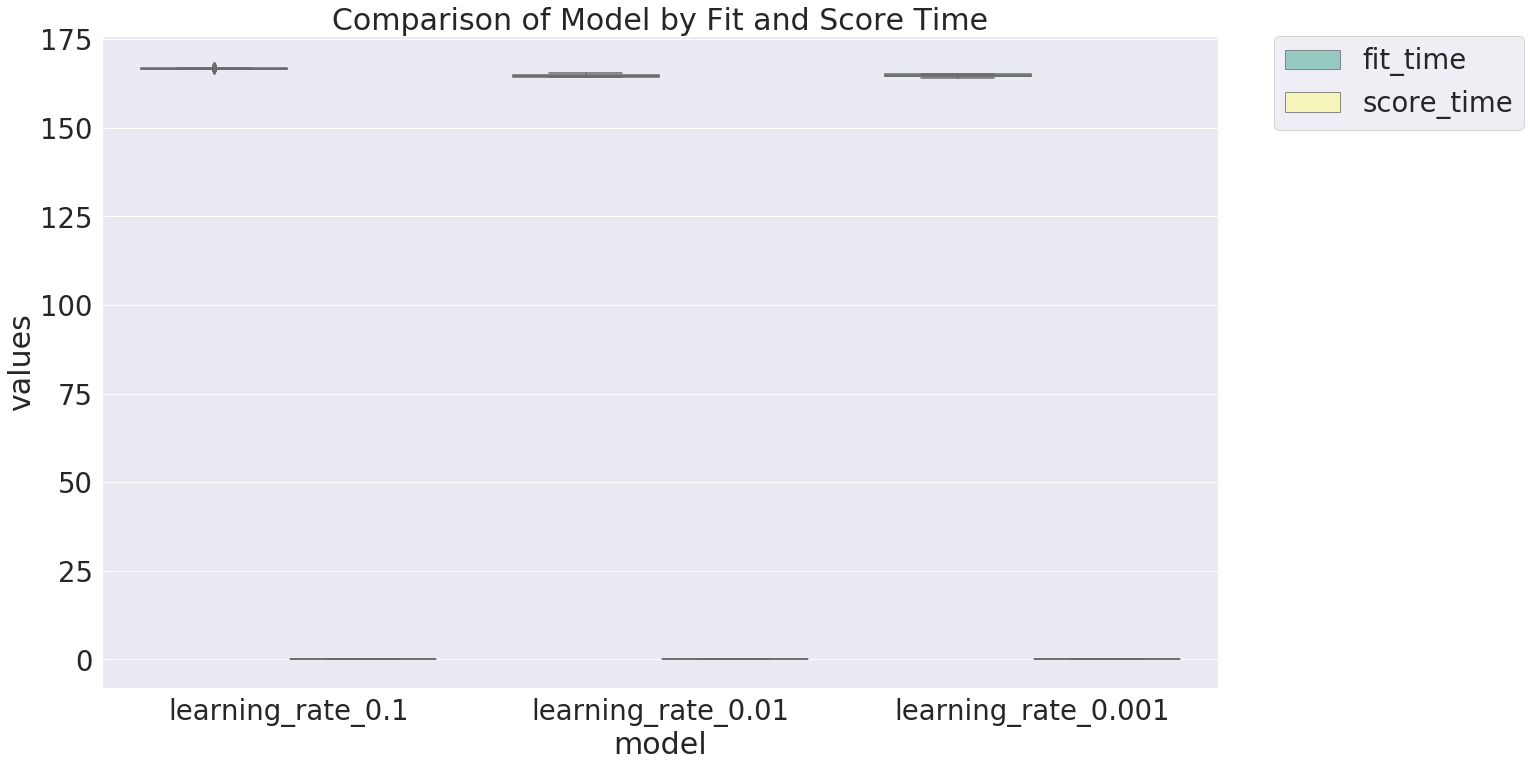

CPU times: user 3.23 s, sys: 5.18 ms, total: 3.24 s
Wall time: 3.25 s


In [14]:
%%time
basic = XGBClassifier(gamma=0.5,
                      learning_rate=0.01, 
                      max_delta_step=0.1, 
                      max_depth=5,
                      min_child_weight=0.2,
                      n_estimators=50,
                      objective='multi:softmax',
                      reg_alpha=0.5,
                      reg_lambda=0.8, 
                      scale_pos_weight=1, 
                      subsample=0.8,
                      n_jobs=12, 
                      gpu_id=0, 
                      tree_method='gpu_hist',
                      validate_parameters=True,
                      verbosity=1)

learning_rate = [0.1, 0.01, 0.001]
models = {}
for n in learning_rate:
    m = copy.deepcopy(basic)
    m.learning_rate = n
    models['learning_rate_' + str(n)] = m

analysis(models, 'xgb_learning_rate')

########################## max_depth_5 ##########################
              precision    recall  f1-score   support

           0       1.00      0.12      0.21        60
           1       0.35      0.85      0.49       720
           2       0.26      0.67      0.37       750
           3       0.17      0.47      0.25       450
           4       0.49      0.37      0.42       660
           5       0.25      0.16      0.20       600
           6       0.88      0.29      0.44       120
           7       0.45      0.20      0.27       480
           8       0.48      0.29      0.36       450
           9       0.87      0.50      0.64       480
          10       0.75      0.41      0.53       660
          11       0.82      0.73      0.77       420
          12       0.85      0.69      0.76       690
          13       0.78      0.77      0.78       720
          14       0.86      0.63      0.73       240
          15       0.85      0.16      0.27       210
          16   

test_accuracy           test_recall_macro            \
                       std      mean               std      mean   
model                                                              
max_depth_5       0.008026  0.567472          0.002509  0.521413   
max_depth_10      0.004198  0.650094          0.003188  0.608698   
max_depth_20      0.005035  0.695943          0.003751  0.648875   

             test_precision_macro           test_f1_macro            
                              std      mean           std      mean  
model                                                                
max_depth_5              0.015632  0.783178      0.005597  0.586520  
max_depth_10             0.009072  0.802254      0.003839  0.664123  
max_depth_20             0.008430  0.805394      0.004869  0.696272

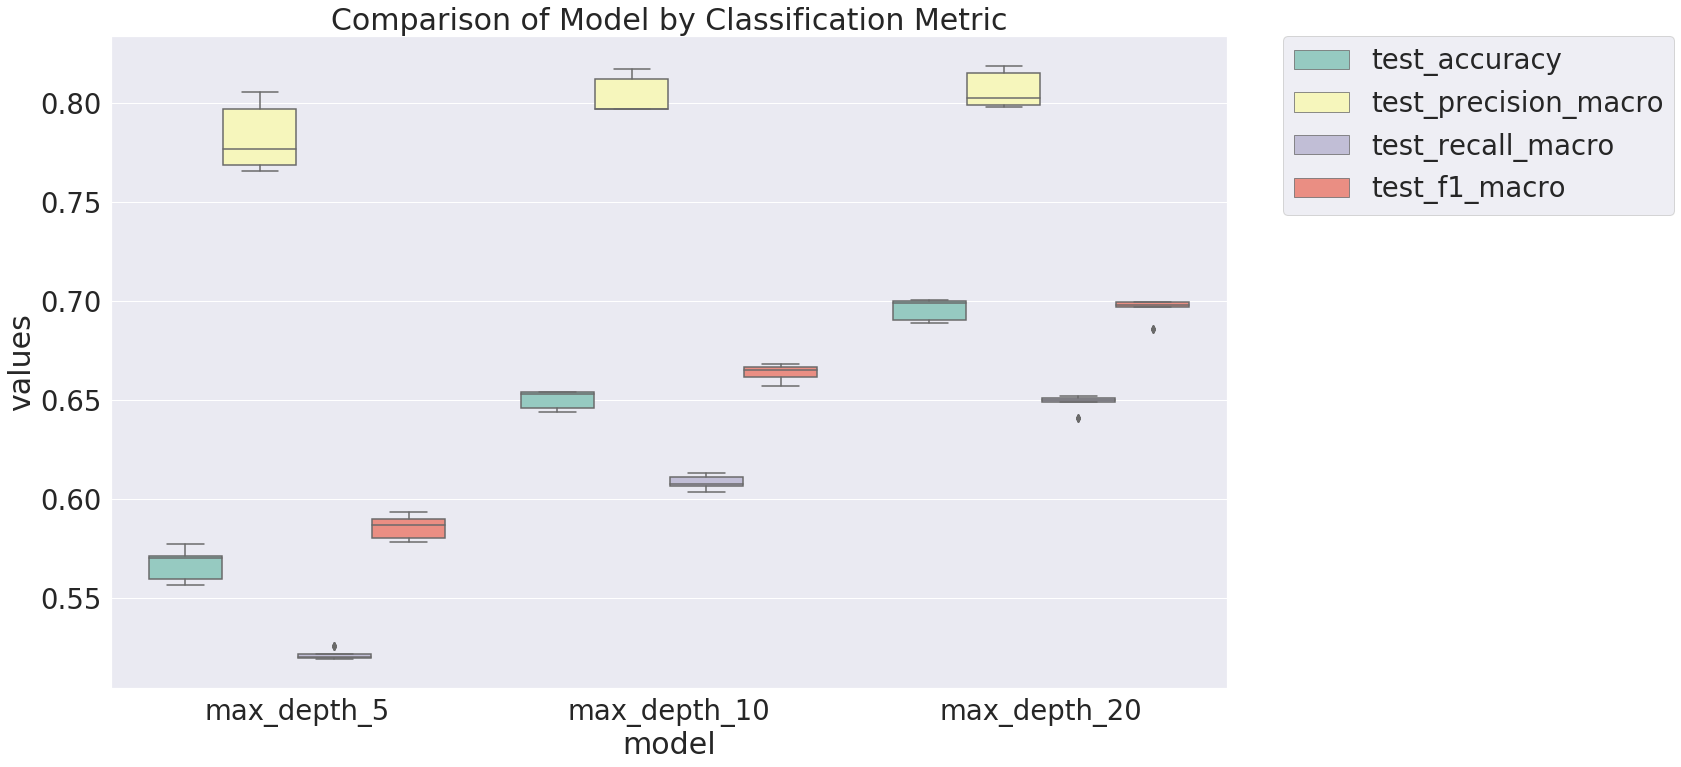

########################## Time ##########################


fit_time             score_time          
                   std        mean        std      mean
model                                                  
max_depth_5   9.506764  169.302621   0.012389  0.222982
max_depth_10  1.017523  239.469925   0.006394  0.238947
max_depth_20  3.994157  269.510612   0.018491  0.263911

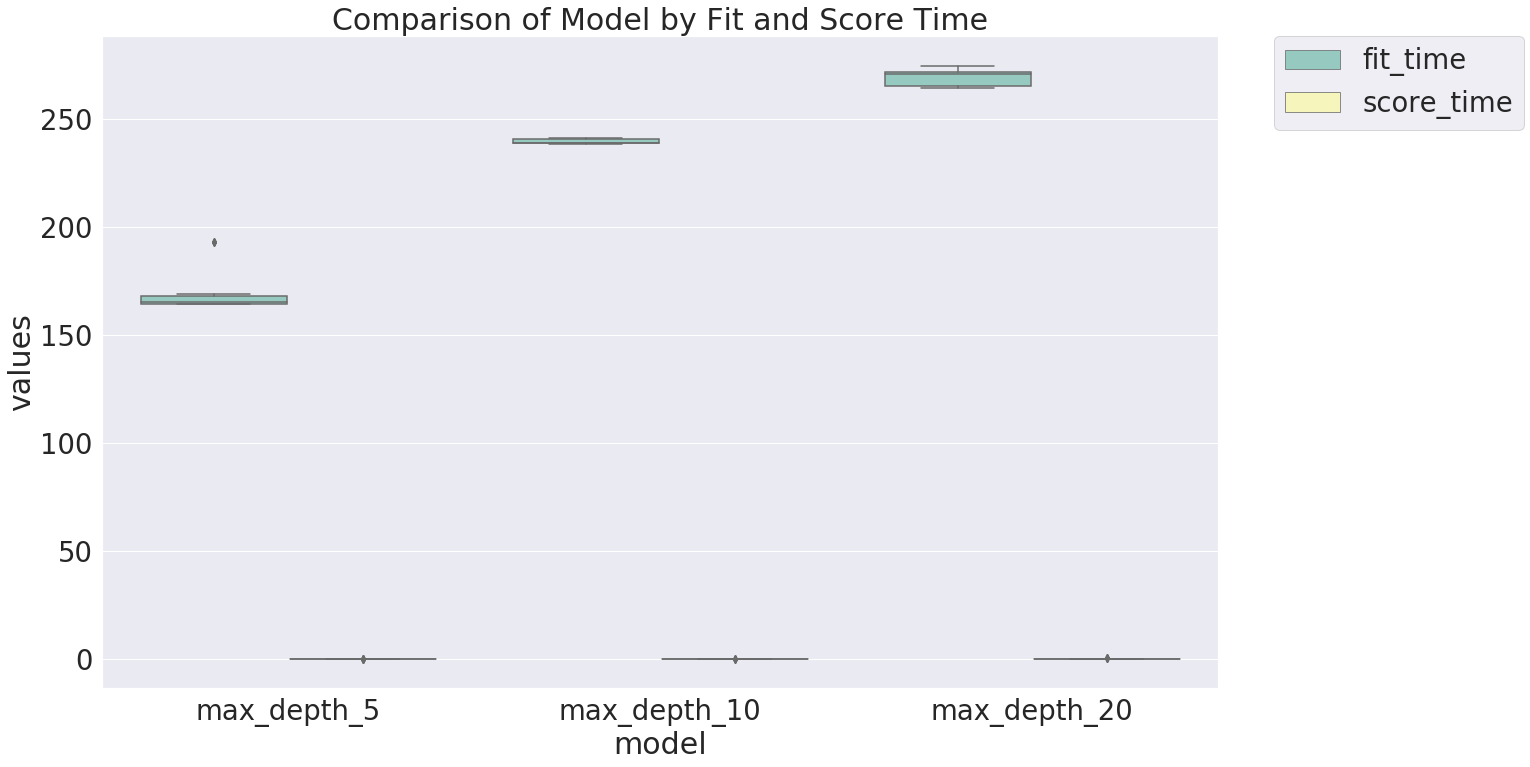

CPU times: user 3.37 s, sys: 20.7 ms, total: 3.39 s
Wall time: 3.39 s


In [15]:
%%time
basic = XGBClassifier(gamma=0.5,
                      learning_rate=0.01, 
                      max_delta_step=0.1, 
                      max_depth=5,
                      min_child_weight=0.2,
                      n_estimators=50,
                      objective='multi:softmax',
                      reg_alpha=0.5,
                      reg_lambda=0.8, 
                      scale_pos_weight=1, 
                      subsample=0.8,
                      n_jobs=12, 
                      gpu_id=0, 
                      tree_method='gpu_hist',
                      validate_parameters=True,
                      verbosity=1)

max_depth = [5, 10, 20]
models = {}
for n in max_depth:
    m = copy.deepcopy(basic)
    m.max_depth = n
    models['max_depth_' + str(n)] = m

analysis(models, 'xgb_max_depth')

########################## num_parallel_tree_1 ##########################
              precision    recall  f1-score   support

           0       1.00      0.12      0.21        60
           1       0.35      0.85      0.49       720
           2       0.26      0.67      0.37       750
           3       0.17      0.47      0.25       450
           4       0.49      0.37      0.42       660
           5       0.25      0.16      0.20       600
           6       0.88      0.29      0.44       120
           7       0.45      0.20      0.27       480
           8       0.48      0.29      0.36       450
           9       0.87      0.50      0.64       480
          10       0.75      0.41      0.53       660
          11       0.82      0.73      0.77       420
          12       0.85      0.69      0.76       690
          13       0.78      0.77      0.78       720
          14       0.86      0.63      0.73       240
          15       0.85      0.16      0.27       210
       

test_accuracy           test_recall_macro            \
                               std      mean               std      mean   
model                                                                      
num_parallel_tree_1       0.007859  0.565009          0.002258  0.521114   
num_parallel_tree_5       0.001746  0.669543          0.002509  0.599062   
num_parallel_tree_10      0.004599  0.696171          0.001860  0.614861   

                     test_precision_macro           test_f1_macro            
                                      std      mean           std      mean  
model                                                                        
num_parallel_tree_1              0.013279  0.778238      0.005247  0.585424  
num_parallel_tree_5              0.004053  0.831187      0.003641  0.660220  
num_parallel_tree_10             0.005296  0.843376      0.001687  0.674175

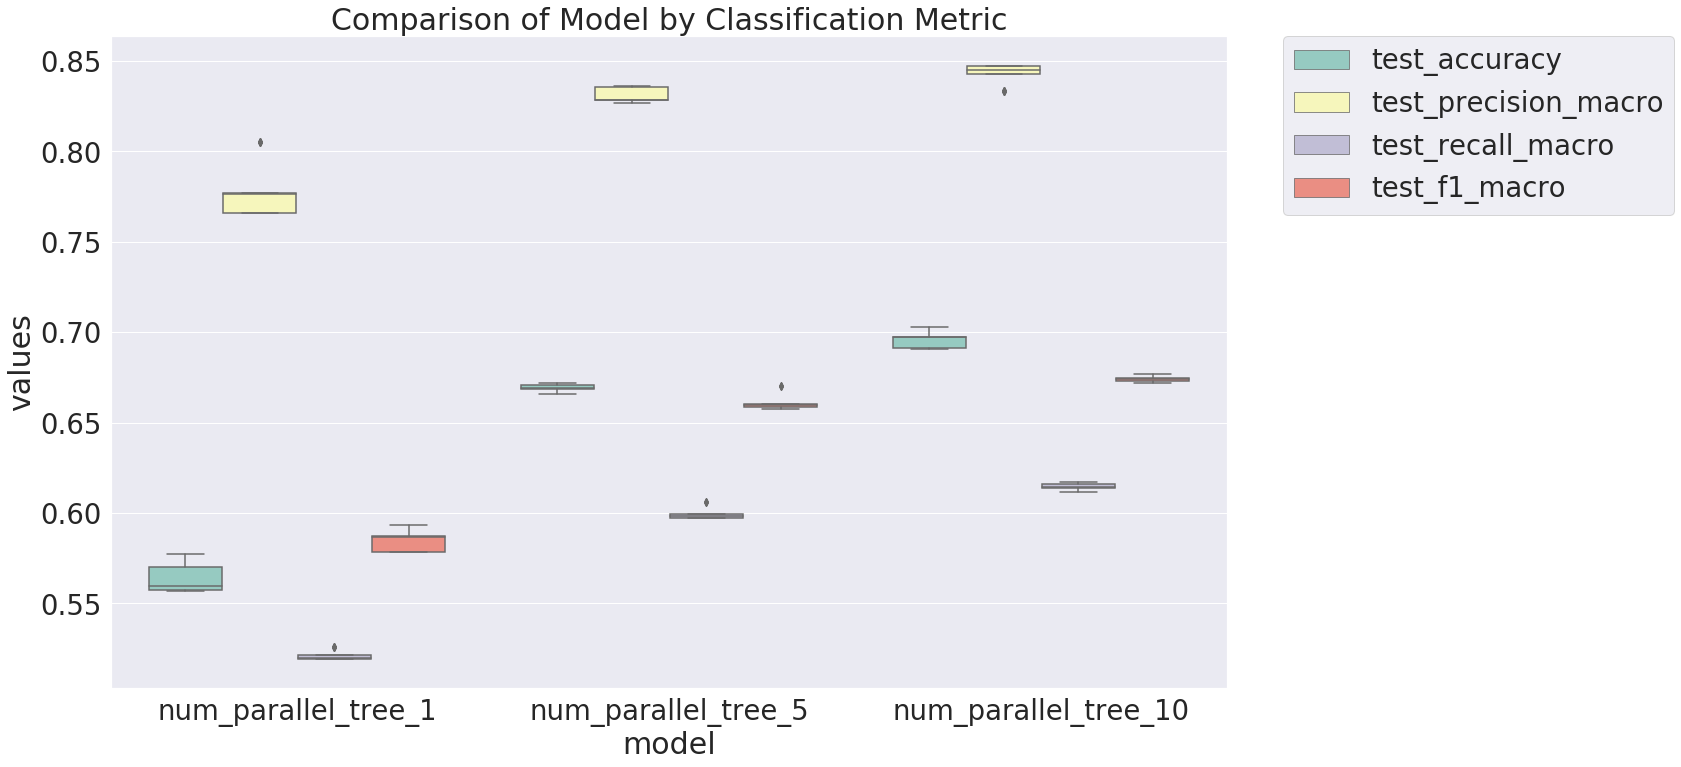

########################## Time ##########################


fit_time              score_time          
                           std         mean        std      mean
model                                                           
num_parallel_tree_1   2.253933   169.191058   0.010977  0.241259
num_parallel_tree_5   9.743123   775.086105   0.024410  0.435491
num_parallel_tree_10  3.266951  1382.036989   0.013491  0.590808

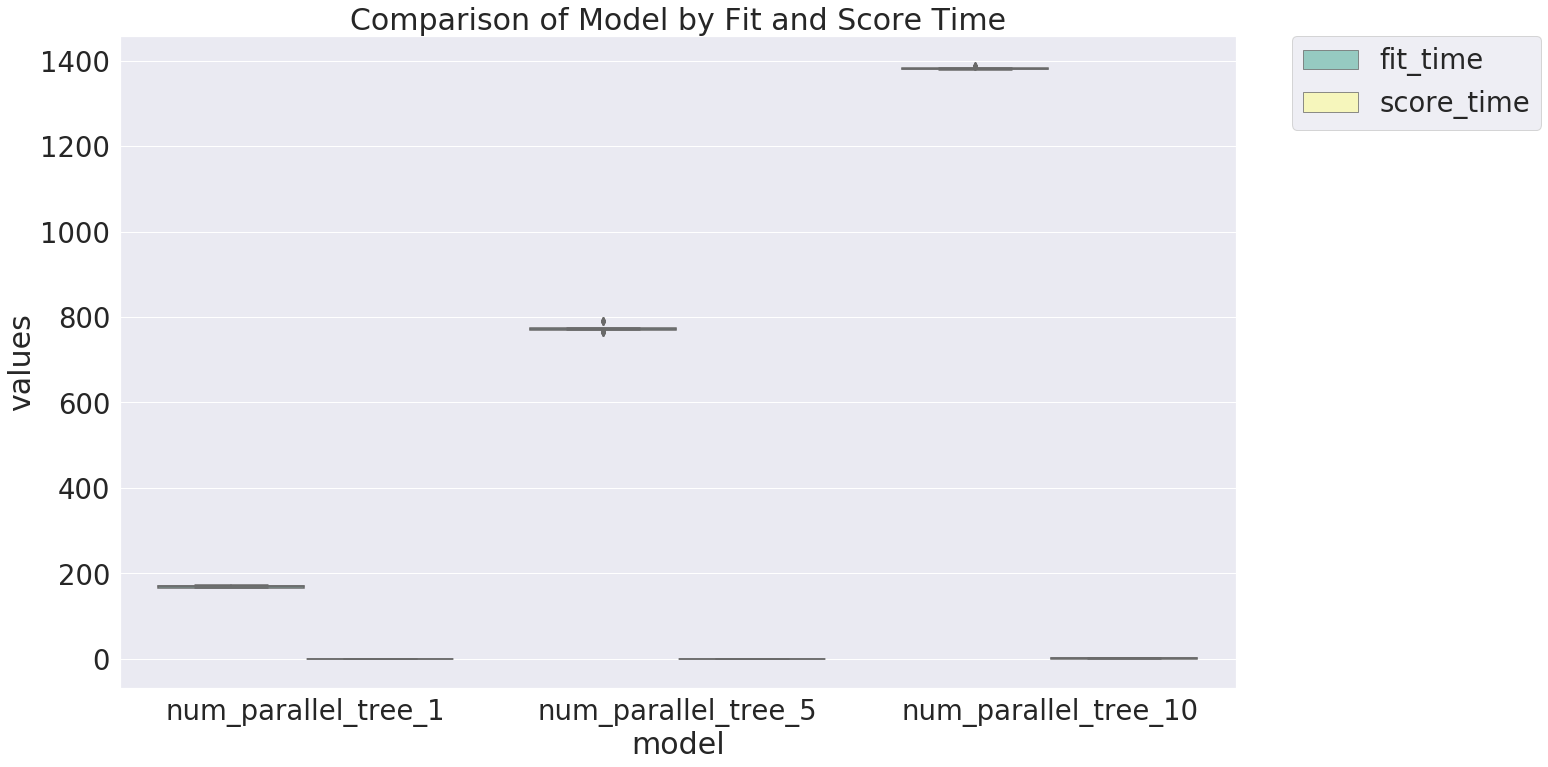

CPU times: user 4.7 s, sys: 31.8 ms, total: 4.73 s
Wall time: 4.76 s


In [16]:
%%time
basic = XGBClassifier(gamma=0.5,
                      learning_rate=0.01, 
                      max_delta_step=0.1, 
                      max_depth=5,
                      num_parallel_tree=None,
                      min_child_weight=0.2,
                      n_estimators=50,
                      objective='multi:softmax',
                      reg_alpha=0.5,
                      reg_lambda=0.8, 
                      scale_pos_weight=1, 
                      subsample=0.8,
                      n_jobs=12, 
                      gpu_id=0, 
                      tree_method='gpu_hist',
                      validate_parameters=True,
                      verbosity=1)

num_parallel_tree = [1, 5, 10]
models = {}
for n in num_parallel_tree:
    m = copy.deepcopy(basic)
    m.num_parallel_tree = n
    models['num_parallel_tree_' + str(n)] = m

analysis(models, 'xgb_num_parallel_tree')